<a href="https://colab.research.google.com/github/highway92/machine_learning/blob/main/year_dream/do/CIFAR10_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Image Classifier


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 위의 autoreload와 autoreload2는 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload하라는 의미이다.
# 자세한 내용이 알고 싶다면 구글링하자 그렇지 않다면 그냥 그렇구나~ 하면 된다.

In [ ]:
!pip install -q bentoml "torch == 1.6.0" " torchvision == 0.7.0" "pillow == 7.2.0"

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 748.8 MB 19 kB/s 
     |████████████████████████████████| 5.9 MB 64.6 MB/s 
     |████████████████████████████████| 2.2 MB 52.3 MB/s 
     |████████████████████████████████| 63 kB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
     |████████████████████████████████| 131 kB 77.7 MB/s 
     |████████████████████████████████| 131 kB 75.3 MB/s 
     |████████████████████████████████| 146 kB 76.2 MB/s 
     |████████████████████████████████| 209 kB 81.1 MB/s 
     |████████████████████████████████| 109 kB 63.5 MB/s 
     |████████████████████████████████| 1.3 MB 63.2 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 144 kB 70.8 MB/s 
     |████

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Trainig an image classifier

딥러닝을 공부하다보면 맨날 영어로 적혀있어서.. 나는 한글로 적어보려고한다.

이제부터 다음과 같은 작업들을 할 것이다.
- torchvision을 사용하여 CIFAR10 데이터셋을 불러오고 normalizing 할것이다.
- Convolutional Nerual Network를 정의할 것이다.
- loss function을 정의 할 것이다.
- train_data를 이용하여 훈련시킬 것이다.
- test_data를 사용하여 테스트도 할 것이다.

이쯤 되니 왜 영어로 적혀있는지 알 것 같다. 그렇지만 최대한 한글로 적어보려 노력하겠다.(그래야 내가 나중에 봐도 알아보기 쉬워서)

# 1. Loading and Normalizing CIFAR10
torchvision 데이터 세트의 출력은 [0,1]의 PILimage이다.
우리는 정규화 하여 [-1,1]사이의 값으로 변환시킬 것이다.

In [ ]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
)
# transforms.ToTensor() 에서 데이터 타입을 Tensor형태로 변경한다.
# 왜 텐서로 변환을 시켜주냐면 pytorch가 tensor타입을 좋아하기 때문이다. 정도로 이해하고 있다.
# Normalize 안의 값은 왜 0.5 일까?
# 이미지의 경우 픽셀 값 하나는 0~255 사이의 값을 가지게 된다.
# 하지만 ToTensor()로 타입 변경시 0 ~ 1 사이의 값으로 변하게 된다.
# 여기서 normalize 하여 -1 ~ 1 사이의 값으로 바꿔주기 위해 0.5가 들어가게 된다.



## Normalize
크게 두가지 연산으로 나눠진다.
- scaling : 데이터의 scale을 줄여준다.
- centering : 데이터의 중심을 원점으로 맞춰준다.(zero-centered)

ToTensor()는 scaling을 해준거고, Normalizing을 거치면서 centering + rescaling을 해준것이다.

## pytorch의 공식문서를 살펴보자.

평균 및 표준 편차를 사용하여 텐서 이미지를 정규화합니다. 이 변환은 PIL 이미지를 지원하지 않습니다. n 채널에 대한 평균: (mean[1],...,mean[n]) 및 표준: (std[1],..,std[n])이 주어지면 이 변환은 입력 토치의 각 채널을 정규화합니다. *텐서 즉, 출력[채널] = (입력[채널] - 평균[채널]) / 표준[채널]


In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './data', train=True, download = True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
# num_worker는 코어의 갯수를 지정해주는 파라미터이다.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


우선 데이터 로더가 왜 필요한지에 대한 궁금증이 있다.

# Dataloader
GPU, CPU는 이미지를 batch 형태로 다룰 때 더 빨리 수행할 수 있다고 한다. pytorch는 Data를 배치 형태 또는 이미지 묶음 형태로 쉽게 바꿀 수 있도록 DataLoader라는 클래스를 제공한다.
DataLoader클래스는 데이터셋을 받아들이고, 일련의 이미지를 반환합니다.

또한 다음과 같은 것들을 해결하기 위해 사용합니다.
- input value setting
- batch나 epoch 등은 어떻게 설정해야 하는지
- 전처리를 하고싶다!
- mnis, cifar10 이런 거 말고 내 자신의 데이터를 쓰고 싶다.

뭐 이런 다양한 이유가 있다고 한다. 좀 더 잘해지면 공감할 수 있을거 같다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min : -1.0 max : 1.0


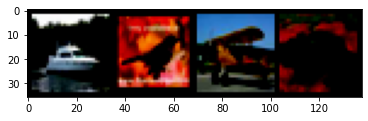

 ship birdplane frog


In [15]:
# 이제 몇개의 데이터를 한번 살펴보자.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
# scale에 따른 시각화차이를 보여주기 위함이다.
# 기억하자 pytorch의 tensor 순서는 (C, H, W) 혹은 (B, C, H, W) 이다.

def imshow(img):
  print(f'img scale min : {img.min()} max : {img.max()}') # -1 ~ 1
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # np.transpose를 해서 (H, W, C) 의 ndarray가 되었다.
  plt.show()


dataiter = iter(trainloader)
images,labels = dataiter.next()

# iter 와 next는 파이썬 문법임으로 궁금하다면 찾아보자

#show images

imshow(torchvision.utils.make_grid(images, nrow=4))
#print labels
print(''.join('%5s' % classes[labels[j]] for j in range(4)))


# torchvision.utils.make_grid() 에 대하여
- 일단 왜쓰는가? : 사람은 항상 궁금증이 많아서 뭐가 들어가고 있는지 보고 싶어 질 때가 있다. 그럴 때 사용한다.

- 어떻게 쓰는가? : 자세한 내용을 알고 싶다면 공홈에 들어가자 여기서는 아주 기본적인 사용법만을 알아볼 것이다.

이 함수를 사용할 때 가장 중요한 것은 바로 batch를 포함한 (b, c, h, w)의 텐서 혹은 같은 사이즈의 이미지 리스트를 포함해야 한다는 것이다. 나머지 파라미터들은 상황에 맞게 사용하면 된다.

이미지 하나만 보고 싶다면 다른 방법을 사용하는 것이 더 좋고,
make_grid()를 사용해서는 여러개의 사진들을 한번에 볼 수 있다는 점이 좋다.

# 2. Define a Convolutional Neural Network


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# CNN(convolutional neural network)
## 필요성
우선 cnn이 왜 필요한지 부터 알아보자..
cnn 개념이 없을 때 이미지 관련 train을 하기 위해서는 각 픽셀을 하나의 입력으로 놓고 진행하게 된다. 이렇게 되면 이미지 크기가 커지거나 망을 깊게 했을 때 parameter의 갯수가 기하급수적으로 증가하게 된다. 또한 이미지의 각 pixel은 같은 중요도를 가지게 되는데 실제로는 중요도가 높고 낮은 영역들이 존재하기에 이를 충분히 반영하지 못하게 된다.

## 그래서?
그래서 나온것이 CNN이다. CNN은 Feature를 추출하는 Convolution Layer와 추출된 Feature를 Sub-Sampling하는 Pooling Layer로 구성되어 있다.(조금 많이 간단하게 말하면 주변의 픽셀들도 고려하여 중요도를 선정한다고 생각하자)



# Convolution
현재 위치의 출력 데이터는 인접한 Pixel에 Convolution Filter를 곱해서 얻어진 값이다. => 인접한 Pixel값의 영향력이 출력데이터라고 생각하면 된다.

위에서 언급한 영향력은 Convolution Filter가 결정하게 되는데 아래의 그림을 보면 조금이나마 이해가 될 것이다. stride나, padding 같은 것들은 나중에 생각하자.

참고로 Filter == Kernel 이란 단어와 같은 의미이다.

![](https://www.researchgate.net/profile/Ihab-S-Mohamed/publication/324165524/figure/fig3/AS:611103423860736@1522709818959/An-example-of-convolution-operation-in-2D-2.png)

예시를 들어보자면 이미지 처리분야에서 유명한 Convolution Filter 로는 Sobel Filter가 있다.

왼쪽의 입력데이터가 가운데의 sobel filter를 거치면 오른쪽 출력 데이터와 같은 Feature Map 이 생성되게 된다.
(sobel filter는 이미지의 윤곽선을 feature로 하는 convolution 연산이다.)

![](https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w03/imgs/sobel1.png)

전통적인 이미지 처리에서는 사용자가 직접 추출하고자 하는 Feature Map에 따라 Convolution Filter 값을 설정해줬다고 한다.

하지만 딥러닝은 학습을 통해 알아서 filter값을 설정한다. 
즉 학습을 통해 불변하는 feature를 출력데이터로 나올 수 있게 filter값을 학습한다고 볼 수 있다.

# Pooling
Pooling은 Convolution과 비슷하게 인접한 Pixel 값만을 사용하지만, 특별히 곱하거나 더하거나 하는 연산은 없다.

대표적인 Pooling 방법은 Max Polling과 Average Pooling이 있다.

Pooling Layer는 다음과 같은 특징이 있다.
- 학습해야 할 매개 변수가 없다.(대상 영역에서 최댓값이나 평균을 취하는 처리이기 때문에 학습할 것이 없다.)
- 채널 수가 변하지 않는다.
- 입력의 변화에 영향을 적게 받아 입력 데이터가 조금 변해도 Pooling의 결과는 잘 변하지 않습니다.

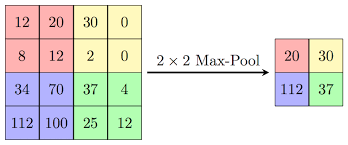

# CNN연산의 Parameter
- Convolution Filter 개수: 각 Layer에서의 연산 시간/량을 비교적 일정하게 유지하여 시스템의 균형을 맞추는 것이 좋다고 한다. 보통 Sub-Sampling을 거치면 1/4로 출력이 줄어들기 때문에 Feature Map의 개수는 대략 4배 정도로 증가시키면 된다.


- Filter Window Size : 작은 필터를 여러 개 중첩하면 중간 단계에 있는 Non-Linearity를 활용하여 원하는 특징을 좀 더 돋보이도록 할 수 있다. 뿐만 아니라 연산량도 적다.
그래서 요즘 대부분의 CNN은 3X3 Filter Window Size를 중첩해서 사용한다.


- Padding : Convolution을 수행하기 전, 입력 데이터 주변을 특정 Pixel값으로 채워 늘리는 것을 말한다. Padding을 사용하는 이유는 출력데이터가 Convolution Layer를 지날 때 마다 작아지게 되고, 가장자리의 정보들이 사라질 수 있기 때문이다.
보통은 Padding을 수행하고, Sub-Sampling으로 데이터를 Resize한다.

- Stride : Window의 이동할 간격을 조절한다. Stride 값이 커지면, 결과 데이터 사이즈가 작아지게 된다.

# LeNet


In [36]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # nn.Conv2d(input_channel, output_channel, filter_size or kernel)
    # conv를 거친 output의 공식은 다음과 같다. (Weight - Fiter size + 2 * Padding) / Stride + 1
    self.pool = nn.MaxPool2d(2, 2)
    # Maxpooling을 2로 하게 되면 input_filter_size의 값을 2로 나눈 값이 output size가 된다.
    # 만약 4로 한다면 4로 나눈값이 될것이다.

    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 *5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# 3. Define a Loss function and optimize

In [37]:
import torch.optim as optim

net = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## CrossEntropyLoss
pytorch에서는 다양한 손실 함수를 제공하는데 그중 CrossEntropyLoss는 다중 분류에 사용된다. CrossEntropyLoss는 nn.LogSoftmax와 nn.NLLLoss 연산의 조합이라고 한다.

- LogSoftmax : 신경단 말단의 결과 값들을 확률 개념으로 해석하기 위한 Softmax 함수의 결과에 log값을 취한 연산
- NLLLoss : LogSoftmax의 결과값에 교차 엔트로피 손실 연산이라고 한다.


# 4. Train the network

In [38]:
for epoch in range(5):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # input 데이터를 가져오자 data 는 [inputs, labels] 형태의 array다

    inputs, labels = data

    inputs = inputs.cuda()
    labels = labels.cuda()

    # 옵티마이져를 초기화 해주자
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.230
[1,  4000] loss: 1.934
[1,  6000] loss: 1.708
[1,  8000] loss: 1.592
[1, 10000] loss: 1.548
[1, 12000] loss: 1.499
[2,  2000] loss: 1.423
[2,  4000] loss: 1.408
[2,  6000] loss: 1.406
[2,  8000] loss: 1.377
[2, 10000] loss: 1.362
[2, 12000] loss: 1.321
[3,  2000] loss: 1.290
[3,  4000] loss: 1.263
[3,  6000] loss: 1.265
[3,  8000] loss: 1.241
[3, 10000] loss: 1.232
[3, 12000] loss: 1.218
[4,  2000] loss: 1.162
[4,  4000] loss: 1.182
[4,  6000] loss: 1.148
[4,  8000] loss: 1.143
[4, 10000] loss: 1.170
[4, 12000] loss: 1.151
[5,  2000] loss: 1.082
[5,  4000] loss: 1.083
[5,  6000] loss: 1.085
[5,  8000] loss: 1.077
[5, 10000] loss: 1.088
[5, 12000] loss: 1.114
Finished Training


# 5. Test the network on the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min : -1.0 max : 1.0


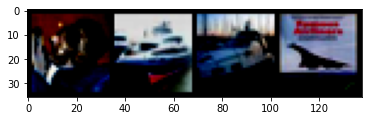

GroundTruth:    cat  ship  ship plane


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # TODO 4: prediction 값을 기준으로 max 값으로 predicted label 만들기 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %
